In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


import h5py
#from read_raw import load_from_file
import maxlab_analysis as mla

import time
from scipy.signal import find_peaks
import scipy.stats as stats
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [2]:
filename = "20660div7.data.raw.h5"


# Read data/make .npy

OSError thrown
(19600, 1020)
(19600,)


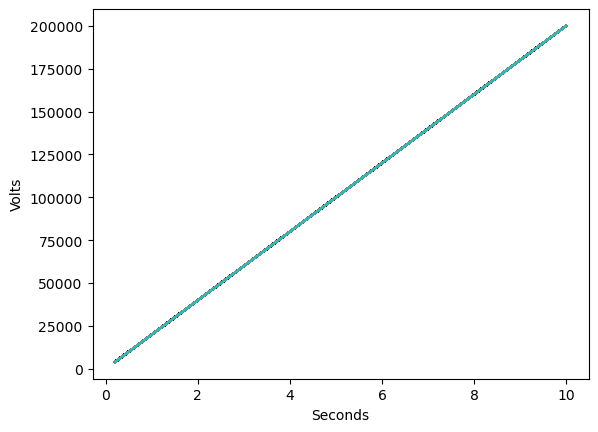

In [3]:
#mla.recording_to_npy(filename, 0, 0)

X, t = mla.load_from_file(filename, 0, 0, 0.2, 10 , 2000)
print(np.shape(X))
print(np.shape(t))
plt.plot(t,X[:,:]);
plt.ylabel('Volts');
plt.xlabel('Seconds');


plt.show()

# plt.savefig('plot.png')

# Spike detection

In [4]:
Y = mla.load_spikes_from_file(filename, 0, 0, -10)
print(np.shape(Y))

(59347, 3)


time taken: 17.2342267036438 s
         time channel  amplitude
2262  0.25030      90 -11.097266
2263  0.25030     407 -13.257250
2265  0.25040     546 -12.796791
2266  0.25055     755 -10.553230
2270  0.25060     262 -13.492403
     time  fraction channels active
0   0.250                  0.193694
1   3.400                  0.177177
2   3.600                  0.157658
3   3.650                  0.160661
4  62.175                  0.462462


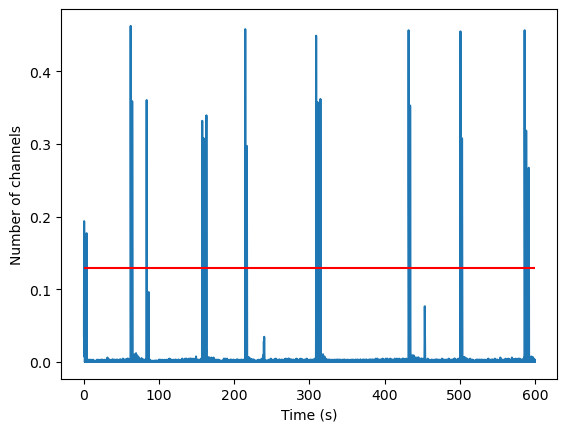

In [5]:
start_time = time.time()
Y_synchronized, spike_times = mla.find_synchronized_spikes(Y, plot_firing = True)
end_time = time.time()
print('time taken: ' + str(end_time - start_time) + ' s')
print(Y_synchronized.head())
print(spike_times.head())

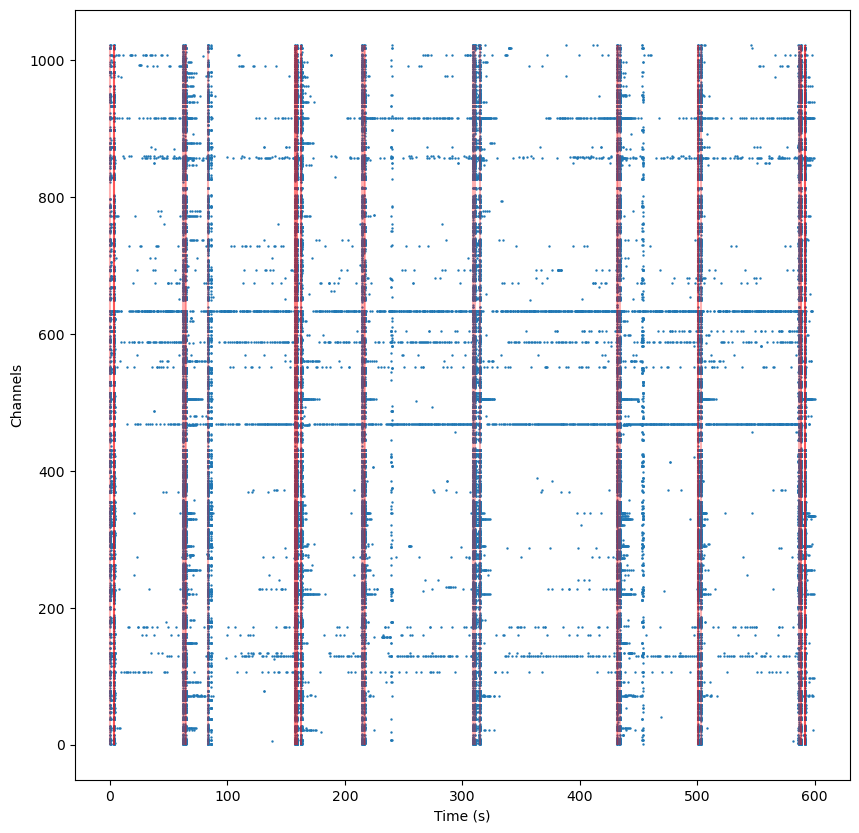

In [6]:
plt.figure(figsize = (10, 10))
plt.scatter(Y['time'], Y['channel'], 0.5)
#plt.scatter(Y_synchronized['frameno'], Y_synchronized['channel'], 1, 'r')
plt.xlabel('Time (s)')
plt.ylabel('Channels')
plt.vlines(spike_times['time'], 0, max(Y['channel']), 'red', alpha=0.3)

In [7]:
spike_diffs = spike_times.diff().dropna()
num_bins = 'auto'

Text(0, 0.5, '$P(IBI) < t$')

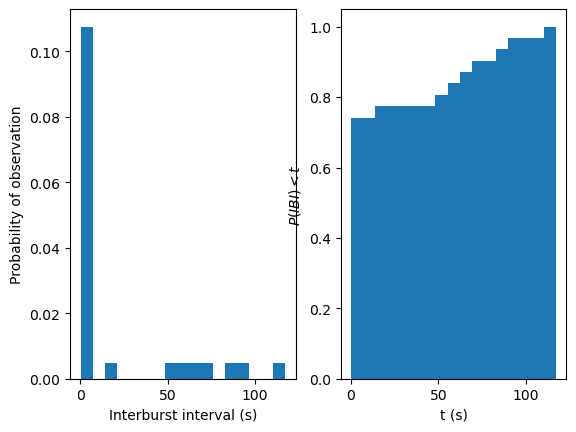

In [8]:
#num_bins = 1000

plt.figure()
plt.subplot(121)
plt.hist(spike_diffs['time'], num_bins, density = True)
plt.xlabel('Interburst interval (s)')
plt.ylabel('Probability of observation')


plt.subplot(122)
plt.hist(spike_diffs['time'], num_bins, density = True, cumulative = True)
plt.xlabel('t (s)')
plt.ylabel('$P(IBI) < t$')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


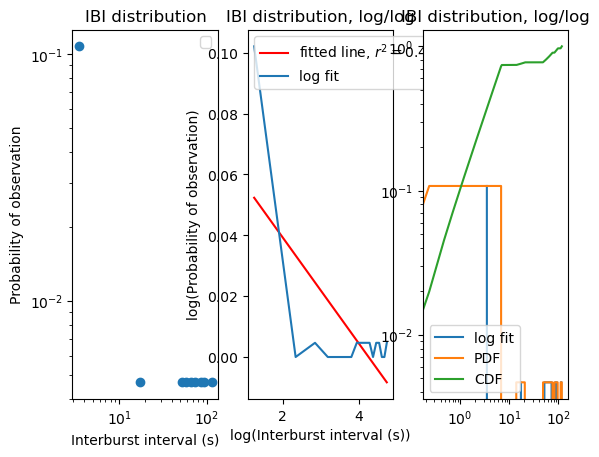

In [9]:
IBI_hist = np.histogram(spike_diffs['time'], bins = num_bins, density = True)
(IBI_data, IBI_bins) = IBI_hist
IBI_bin_midpoints = [(a + b) /2 for a,b in zip(IBI_bins[:-1], IBI_bins[1:])]

hist_dist = stats.rv_histogram(IBI_hist, density = True)
X = np.linspace(0, max(spike_diffs['time']), 500)

plt.figure()
plt.subplot(131)
plt.title('IBI distribution')
plt.scatter(IBI_bin_midpoints, IBI_data)
#plt.plot(X, hist_dist.pdf(X), label= 'PDF')
#plt.plot(X, hist_dist.cdf(X), label= 'CDF')

plt.legend()

plt.xlabel('Interburst interval (s)')
plt.ylabel('Probability of observation')
plt.yscale('log')
plt.xscale('log')

plt.subplot(132)
#NOTE - THIS NAN_TO_NUM THING IS HAPPENING
log_IBI_bin_midpoints = np.log(IBI_bin_midpoints)
log_IBI_data = np.log1p(IBI_data)

fit = stats.linregress(log_IBI_bin_midpoints, log_IBI_data)
plt.plot(log_IBI_bin_midpoints, fit.intercept + fit.slope*log_IBI_bin_midpoints, 'r', label=f'fitted line, $r^2 = {fit.rvalue**2:.2f}$')

plt.title('IBI distribution, log/log')
#plt.hist(spike_diffs['time'], num_bins, density = True)
plt.plot(log_IBI_bin_midpoints, log_IBI_data, label = "log fit")
#plt.loglog(X, hist_dist.pdf(X), label= 'PDF')
#plt.loglog(X, hist_dist.cdf(X), label= 'CDF')

plt.legend()

plt.xlabel('log(Interburst interval (s))')
plt.ylabel('log(Probability of observation)')

plt.subplot(133)
plt.title('IBI distribution, log/log')
#plt.hist(spike_diffs['time'], num_bins, density = True)
plt.loglog(IBI_bin_midpoints, IBI_data, label = "log fit")
plt.loglog(X, hist_dist.pdf(X), label= 'PDF')
plt.loglog(X, hist_dist.cdf(X), label= 'CDF')

plt.legend()

#plt.xlabel('log(Interburst interval (s))')
#plt.ylabel('log(Probability of observation)')

# Import data from npy

In [10]:
data_from_npy = np.load(filename + '.npy', mmap_mode = 'r', )
#scale data

t = data_from_npy[:, 0]
X = data_from_npy[:, 1::2]

# PCA

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

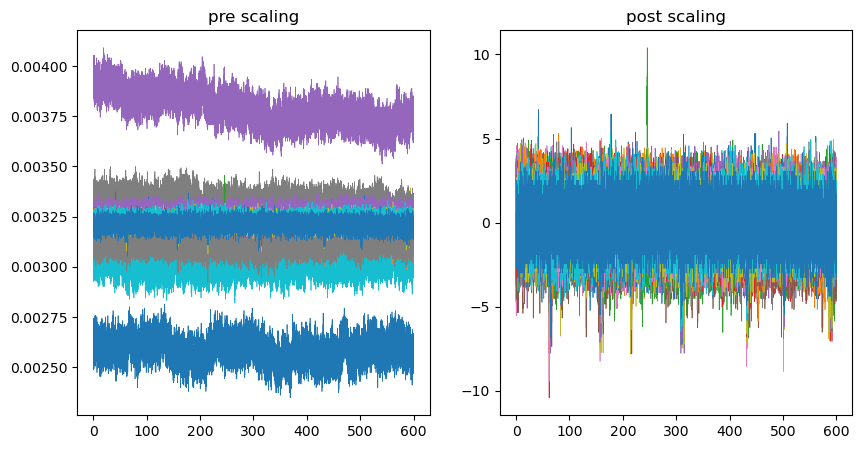

In [12]:
#Plot a subset of the channels
plt.figure(figsize = (10, 5))
plt.subplot(121)
plt.plot(t[:], X[:, ::10], linewidth = 0.5)
plt.title('pre scaling')

plt.subplot(122)
plt.plot(t[:], X_scaled[:, ::10], linewidth = 0.5)
plt.title('post scaling')
plt.show()



In [13]:
n_components = 6

pca = PCA(n_components)
X_pca = pca.fit_transform(X_scaled)

print(pca.explained_variance_ratio_)

[0.04746159 0.0147992  0.01018912 0.00715957 0.00579164 0.00502284]


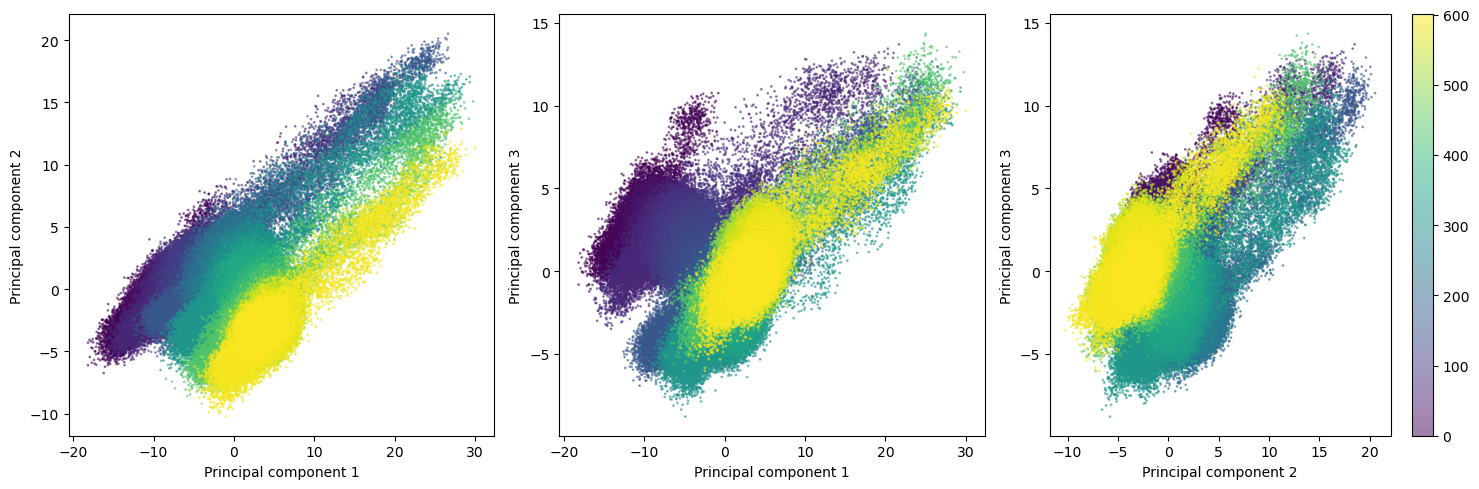

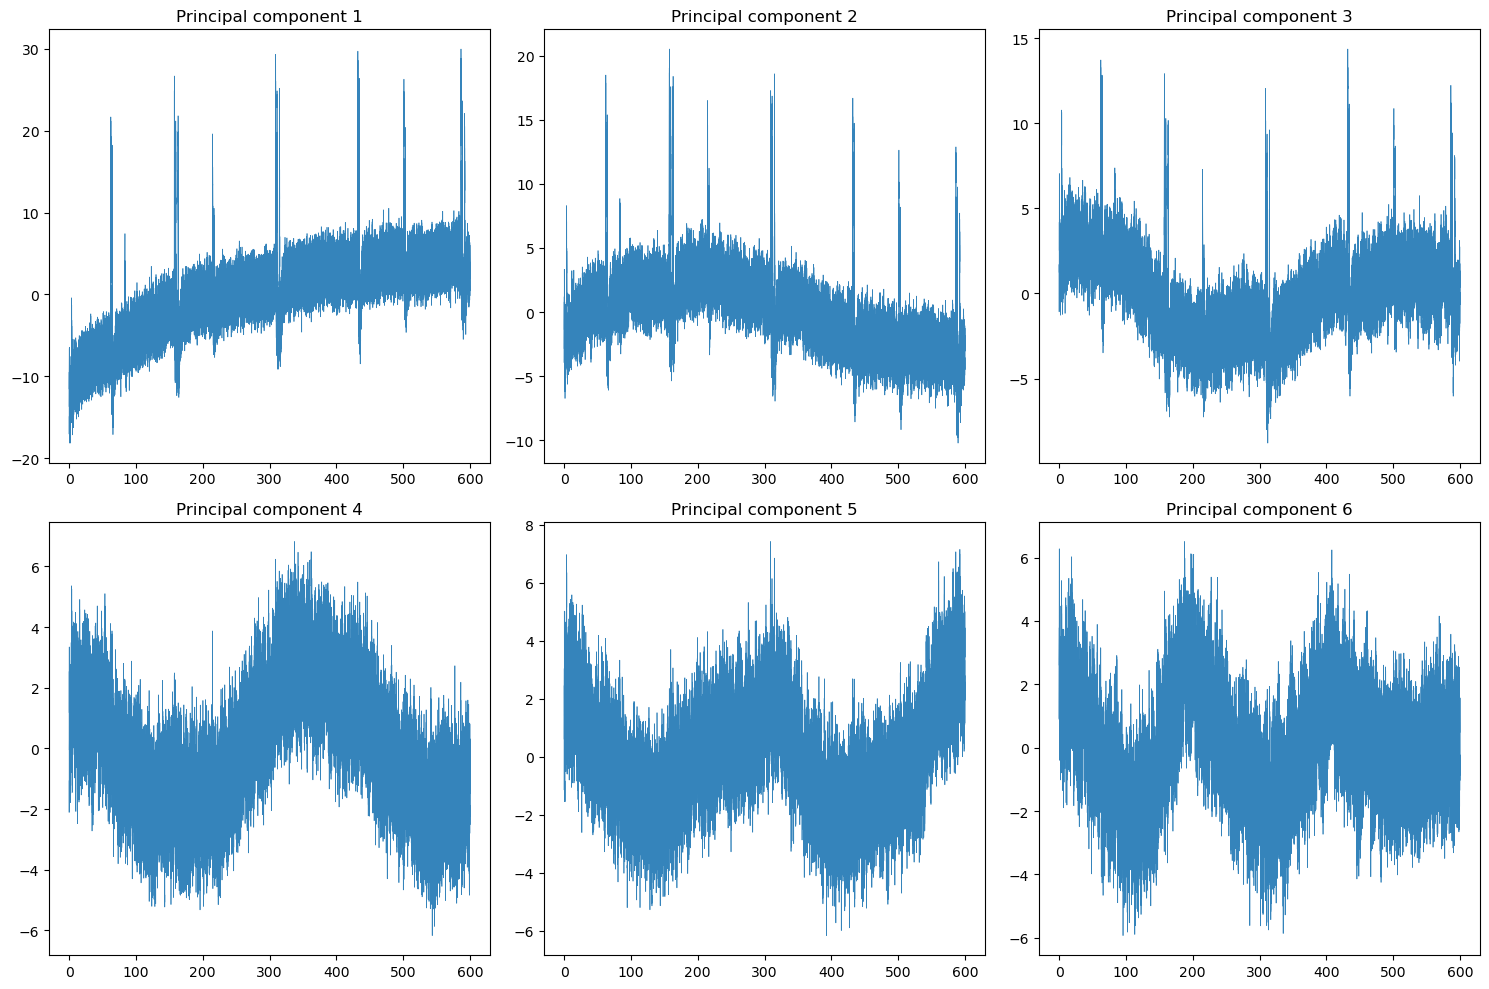

In [14]:
%matplotlib inline
fig = plt.figure(figsize = (15, 5))

plt.subplot(131)

plt.scatter(X_pca[:, 0], X_pca[:, 1],  s = 1, c = t, alpha = 0.5)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

plt.subplot(132)

plt.scatter(X_pca[:, 0], X_pca[:, 2],  s = 1, c = t, alpha = 0.5)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 3')

plt.subplot(133)
plt.scatter(X_pca[:, 1], X_pca[:, 2],  s = 1, c = t, alpha = 0.5)
plt.colorbar()
plt.xlabel('Principal component 2')
plt.ylabel('Principal component 3')
plt.tight_layout()
plt.show()

fig_width = 3
plt.figure(figsize = (fig_width * 5, (int(np.ceil(n_components/fig_width)) * 5)))
for i in np.arange(1, n_components + 1):
    plt.subplot(int(np.ceil(n_components/fig_width)), fig_width, i)
    plt.plot(t, X_pca[:, i-1], linewidth = 0.5, alpha = 0.9)
    plt.title('Principal component ' + str(i))
plt.tight_layout()
plt.show()

In [15]:
%matplotlib notebook
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection='3d')
p = ax.scatter(X_pca[:125000:30, 0], X_pca[:125000:30, 1], X_pca[:125000:30, 2], s = 1, c = t[:125000:30], alpha = 0.5)
ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')
ax.set_zlabel('principal component 3')
fig.colorbar(p)
plt.tight_layout()
fig.show()


<IPython.core.display.Javascript object>

In [16]:
%matplotlib notebook
end_time = 10
step = 0.1
def animate_func(num):
    #ax.clear()
    p = ax.scatter(X_pca[num, 0], X_pca[num, 1], X_pca[num, 2], c = t[num], s = 2, alpha = 0.5)
    ax.set_xlim3d([np.min(X_pca[:, 0]), np.max(X_pca[:, 0])])
    ax.set_ylim3d([np.min(X_pca[:, 1]), np.max(X_pca[:, 1])])
    ax.set_zlim3d([np.min(X_pca[:, 2]), np.max(X_pca[:, 2])])

    ax.set_xlabel('Principal component 1')
    ax.set_ylabel('Principal component 2')
    ax.set_zlabel('principal component 3')

    ax.set_title('Time = ' + str(np.round(t[num] * 1000, decimals = 3)) + 'ms')

fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection='3d')

animation = FuncAnimation(fig, animate_func, interval = 100, frames = np.arange(0, end_time * 1250, step * 1250, dtype = int))
plt.show()

<IPython.core.display.Javascript object>

In [17]:
%matplotlib notebook
end_time = 10
step = 0.1

pc1_lims = [np.min(X_pca[:, 0]), np.max(X_pca[:, 0])]
pc2_lims = [np.min(X_pca[:, 1]), np.max(X_pca[:, 1])]
pc3_lims = [np.min(X_pca[:, 2]), np.max(X_pca[:, 2])]

def animate_func(num):
    #ax.clear()
    plt.subplot(121)
    plt.scatter(X_pca[num, 0], X_pca[num, 1], c = t[num], s = 2, alpha = 0.5)
    plt.xlabel('Principal component 1')
    plt.ylabel('Principal component 2')
    plt.xlim(pc1_lims)
    plt.ylim(pc2_lims)

    
    plt.subplot(122)
    plt.scatter(X_pca[num, 0], X_pca[num, 2], c = t[num], s = 2, alpha = 0.5)
    plt.xlabel('Principal component 1')
    plt.ylabel('Principal component 3')
    plt.xlim(pc1_lims)
    plt.ylim(pc3_lims)

    plt.title('Time = ' + str(np.round(t[num] * 1000, decimals = 3)) + 'ms')

fig = plt.Figure(figsize = (10, 10))

animation = FuncAnimation(fig, animate_func, interval = 100, frames = np.arange(0, end_time * 1250, step * 1250, dtype = int))
plt.show()

# NMF

In [18]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [19]:
#Plot a subset of the channels
plt.figure(figsize = (10, 5))
plt.subplot(121)
plt.plot(t[:], X[:, ::10], linewidth = 0.5)
plt.title('pre scaling')

plt.subplot(122)
plt.plot(t[:], X_scaled[:, ::10], linewidth = 0.5)
plt.title('post scaling')
plt.show()

<IPython.core.display.Javascript object>

c:\Users\nwu04\AppData\Local\anaconda3\lib\site-packages\matplotlib\animation.py:880: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [20]:

n_components = 3

nmf = NMF(n_components, max_iter = 200)
X_nmf = nmf.fit_transform(X)#NOTE: does not use the scaled version. It takes a hella long time

print(nmf.n_features_in_)

In [ ]:
fig = plt.figure(figsize = (15, 5))

plt.subplot(131)

plt.scatter(X_nmf[:, 0], X_nmf[:, 1],  s = 1, c = t, alpha = 0.5)
plt.xlabel('NMF component 1')
plt.ylabel('NMF component 2')

plt.subplot(132)

plt.scatter(X_nmf[:, 0], X_nmf[:, 2],  s = 1, c = t, alpha = 0.5)
plt.xlabel('NMF component 1')
plt.ylabel('NMF component 3')

plt.subplot(133)
plt.scatter(X_nmf[:, 1], X_nmf[:, 2],  s = 1, c = t, alpha = 0.5)
plt.colorbar()
plt.xlabel('NMF component 2')
plt.ylabel('NMF component 3')
plt.tight_layout()
plt.show()


fig_width = 3
plt.figure(figsize = (fig_width * 5, (int(np.ceil(n_components/fig_width)) * 5)))
for i in np.arange(1, n_components + 1):
    plt.subplot(int(np.ceil(n_components/fig_width)), fig_width, i)
    plt.plot(t, X_nmf[:, i-1], linewidth = 0.5, alpha = 0.9)
    plt.title('NMF component ' + str(i))
plt.tight_layout()
plt.show()

In [ ]:

n_components = 3

nmf = NMF(n_components, max_iter=2000) #enough to converge!
X_nmf_scaled = nmf.fit_transform(X_scaled)

print(nmf.n_features_in_)

In [ ]:
fig = plt.figure(figsize = (15, 5))

plt.subplot(131)

plt.scatter(X_nmf_scaled[:, 0], X_nmf_scaled[:, 1],  s = 1, c = t, alpha = 0.5)
plt.xlabel('NMF component 1')
plt.ylabel('NMF component 2')

plt.subplot(132)

plt.scatter(X_nmf_scaled[:, 0], X_nmf_scaled[:, 2],  s = 1, c = t, alpha = 0.5)
plt.xlabel('NMF component 1')
plt.ylabel('NMF component 3')

plt.subplot(133)
plt.scatter(X_nmf_scaled[:, 1], X_nmf_scaled[:, 2],  s = 1, c = t, alpha = 0.5)
plt.colorbar()
plt.xlabel('NMF component 2')
plt.ylabel('NMF component 3')
plt.tight_layout()
plt.show()


fig_width = 3
plt.figure(figsize = (fig_width * 5, (int(np.ceil(n_components/fig_width)) * 5)))
for i in np.arange(1, n_components + 1):
    plt.subplot(int(np.ceil(n_components/fig_width)), fig_width, i)
    plt.plot(t, X_nmf_scaled[:, i-1], linewidth = 0.5, alpha = 0.9)
    plt.title('NMF component ' + str(i))
plt.tight_layout()
plt.show()